In [40]:
%load_ext autoreload
%autoreload 2

import torch 
import pyro
import inspect

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData import GenerateData, check_data, check_and_plot_data
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_plain, make_lm_program_gamma_gamma, make_lm_program_gamma_gamma_augmented
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code

        def multivariate_lm_return_dict(x: torch.tensor, y: torch.tensor = None) -> dict:
                sigma_squared = (pyro.sample("sigma_squared", pyro.distributions.Gamma(a0, b0)) + 0.1)/10000
                
                tau = (pyro.sample("tau", pyro.distributions.Gamma(a1,b1)) + 0.1)/10

                beta_mean = torch.zeros(x.shape[1])
                beta_cov = (1/tau) * torch.eye(x.shape[1])

                beta = pyro.sample("beta", pyro.distributions.MultivariateNormal(beta_mean, beta_cov))

                mean = torch.matmul(x, beta)

                with pyro.plate("data", len(x)):
                        y = pyro.sample("obs", pyro.distributions.Normal(mean, sigma_squared), obs=y)

                return {
                        "x": x,
                        "y": y,
                        "sigma_squared": sigma_squared,
                        "tau": tau,
                        "beta": beta
                }



100%|██████████| 1000/1000 [00:01<00:00, 773.76it/s]


Discarded 0 samples
{'X': {'mean': tensor(0.5000), 'variance': tensor(0.0834), 'min': tensor(1.2517e-06), 'max': tensor(1.0000)}, 'y': {'mean': tensor(-0.0198), 'variance': tensor(4.9086), 'min': tensor(-10.6805), 'max': tensor(16.0504)}, 'beta': {'mean': tensor([-0.0558,  0.0157,  0.0093]), 'variance': tensor([5.0303, 4.8770, 5.2195]), 'min': tensor([-7.8490, -8.0011, -8.7611]), 'max': tensor([12.0784,  9.9393, 11.0783])}}
Statistics for sigma_squared:
Mean: 0.00026647280901670456
Variance: 1.2801398163730937e-08
Min: 5.852946196682751e-05
Max: 0.0007402894552797079


Statistics for tau:
Mean: 0.2537151575088501
Variance: 0.011893571354448795
Min: 0.0456341877579689
Max: 0.6996963024139404




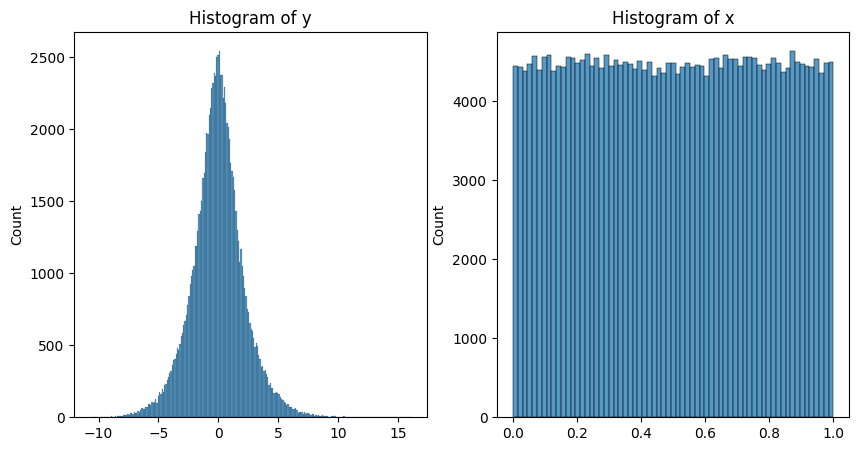

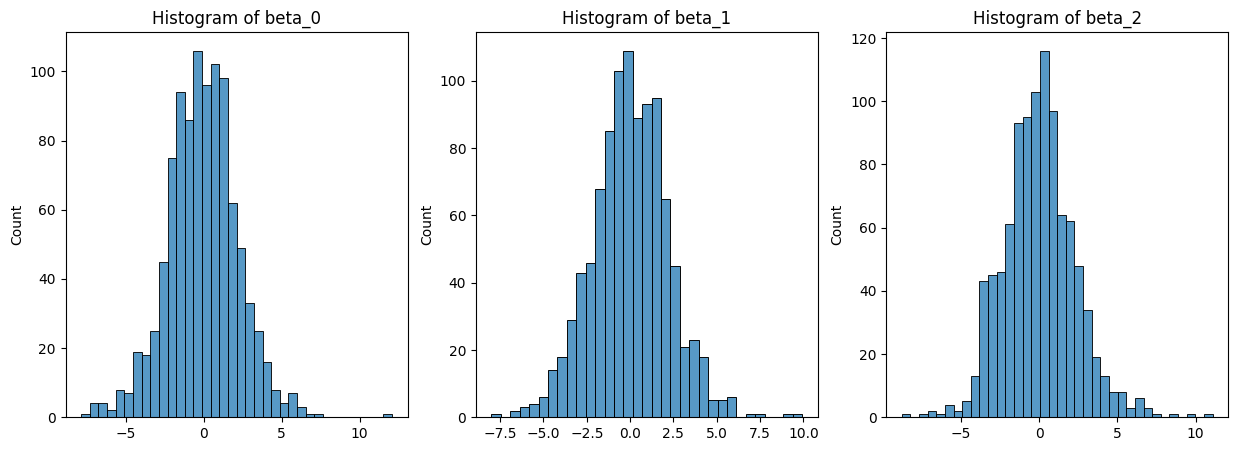

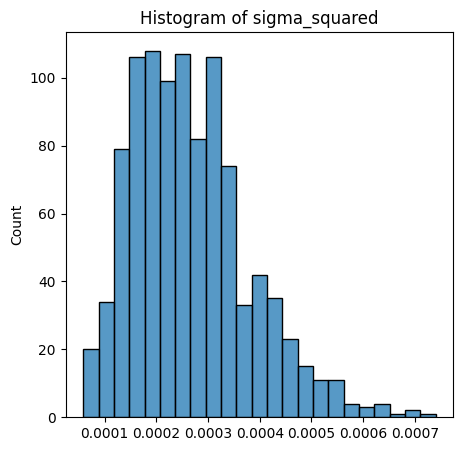

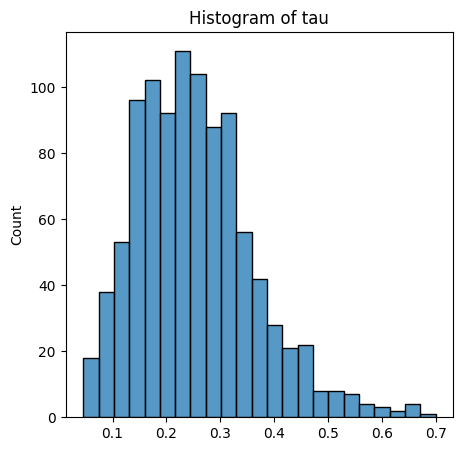

In [42]:
x_test = torch.rand(10, 5)
pprogram1 = make_lm_program_gamma_gamma_augmented()
pprogram1_y = return_only_y(pprogram1)
pprogram1
print_code(pprogram1)
generator = GenerateData(pprogram1)
generator.render_model()
_ = generator.check_model()


In [57]:
loader = generator.make_dataloaders_dynamic(
    n_batch=1000,
    
)

In [58]:
train_loader, val_loader, test_loader = loader

In [59]:
from PFNExperiments.LinearRegression.Models.Transformer import Transformer

In [60]:
batch = next(iter(train_loader))
x = batch['x']
y = batch['y']
beta = batch['beta']

In [61]:
print(x.shape)

torch.Size([256, 100, 5])


In [62]:
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

In [63]:
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

In [64]:
batch = next(iter(train_loader))
x = batch['x']
y = batch['y']
beta = batch['beta']
print(x.shape)
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

torch.Size([256, 100, 5])


In [65]:
def batch_to_model(batch:dict) -> torch.tensor:
    x = batch['x']
    y = batch['y']
    X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)
    return X_y

In [66]:
model = Transformer(
    n_features=6,
    seq_len=100,
    d_model=126,
    n_heads=2,
    dim_feedforward=126,
    n_layers=4,
    n_output_units_per_head=[5, 5*5, 5]
)

In [67]:
out = model(X_y)

In [68]:
mu, cov_factor, cov_diag = out

In [69]:
from PFNExperiments.Training.Trainer import Trainer, batch_to_model_lm, visualize_results
from PFNExperiments.Training.Losses import MSELoss_unsqueezed

from PFNExperiments.Training.EvalMetrics import mean_squared_error_torch_avg, mae_torch_avg, r2_score_torch_avg

In [70]:
def get_transformer_schedule_with_warmup(optimizer, d_model, warmup_steps):
    """
    Returns a scheduler with a learning rate that increases linearly from 0 to 1 over `warmup_steps` training steps,
    and decreases proportionally to the inverse square root of the step number after `warmup_steps`.
    """
    def lr_lambda(step_num):
        # Scale the learning rate according to the transformer schedule
        step_num = max(1, step_num)
        return d_model ** (-0.5) * min(step_num ** (-0.5), step_num * warmup_steps ** (-1.5))

    return LambdaLR(optimizer, lr_lambda)

# Example usage:
# Assuming `model` is your transformer model and `optimizer` is initialized with your model parameters
d_model = 1024
warmup_steps = 4000


optimizer = torch.optim.Adam(model.parameters(), lr=0.0, betas=(0.9, 0.98), eps=1e-9)
scheduler = get_transformer_schedule_with_warmup(optimizer, d_model, warmup_steps)

NameError: name 'LambdaLR' is not defined

In [71]:
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian

In [72]:
nll_loss = ModelPosteriorFullGaussian(cov_reg_factor = 1e-6).negative_log_likelihood
nll_loss_avg = ModelPosteriorFullGaussian(cov_reg_factor = 1e-6).negative_log_likelihood_avg

In [73]:
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

In [77]:
additional_evals = {
    "loss": nll_loss_avg,
}
trainer = Trainer(
    model = model,
    optimizer=opt,
    scheduler = None,
    loss_function=nll_loss,
    trainset = train_loader,
    valset=val_loader,
    evaluation_functions= additional_evals,
    n_epochs = 10,
    early_stopping_patience = 20  
)

In [78]:
trainer.validate()

{'loss': tensor(11.1508)}

In [79]:
r = trainer.train()

100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


Epoch 0:
Training: {'loss': tensor(10.9760)}
Validation: {'loss': tensor(10.8446)}
Time: 5.4632978439331055


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


Epoch 1:
Training: {'loss': tensor(11.0317)}
Validation: {'loss': tensor(11.5471)}
Time: 7.201314926147461


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


Epoch 2:
Training: {'loss': tensor(11.1154)}
Validation: {'loss': tensor(10.5204)}
Time: 7.511051416397095


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


Epoch 3:
Training: {'loss': tensor(11.1285)}
Validation: {'loss': tensor(10.7443)}
Time: 7.559914588928223


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


Epoch 4:
Training: {'loss': tensor(11.4367)}
Validation: {'loss': tensor(11.3178)}
Time: 7.7372071743011475


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 5:
Training: {'loss': tensor(11.2236)}
Validation: {'loss': tensor(10.6842)}
Time: 5.5549633502960205


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch 6:
Training: {'loss': tensor(11.3680)}
Validation: {'loss': tensor(11.0475)}
Time: 5.58388876914978


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch 7:
Training: {'loss': tensor(11.9528)}
Validation: {'loss': tensor(10.9051)}
Time: 5.904294729232788


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 8:
Training: {'loss': tensor(11.8579)}
Validation: {'loss': tensor(10.9502)}
Time: 5.5025293827056885


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


Epoch 9:
Training: {'loss': tensor(11.2790)}
Validation: {'loss': tensor(11.1896)}
Time: 6.189019680023193


----------------------------------------------------------------------------------------------------


In [80]:
model = trainer.model

TypeError: 'Axes' object is not subscriptable

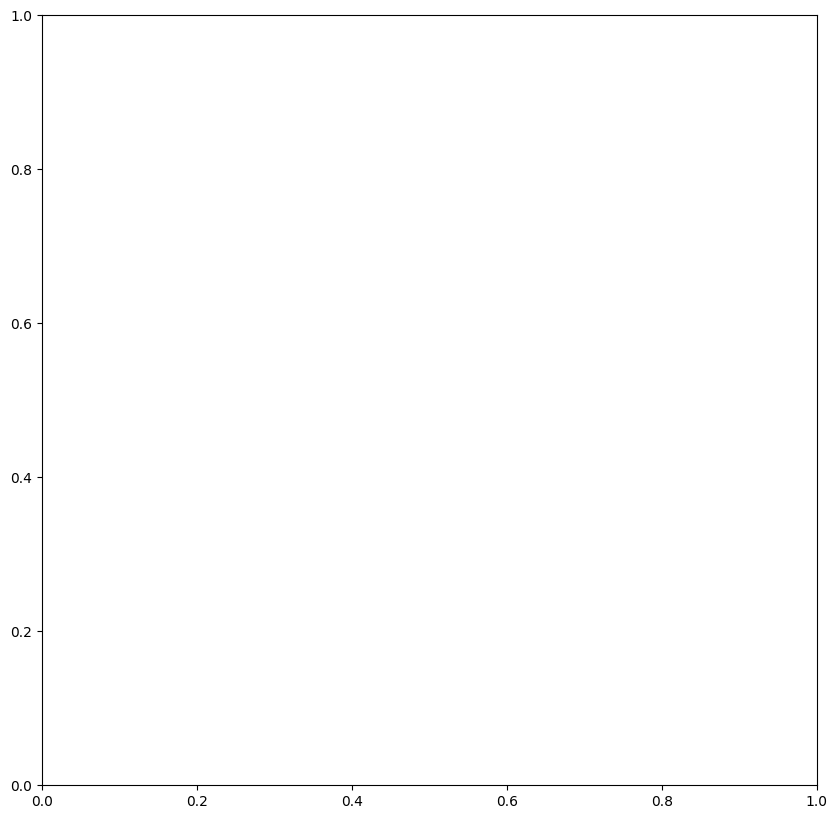

In [81]:
visualize_results(r)

In [104]:
from PFNExperiments.LinearRegression.Models.ModelToPosterior import ModelToPosterior

In [112]:
full_model = ModelToPosterior(model, ModelPosteriorFullGaussian(cov_reg_factor = 1e-6))

In [116]:
X_y.shape

torch.Size([256, 100, 6])

In [117]:

target_dist = full_model.input_to_posterior(X_y)


In [118]:
samples_my_posterior = target_dist.sample((1000,))

In [120]:
samples_my_posterior = samples_my_posterior[:, 0, :]

In [121]:
samples_my_posterior.shape

torch.Size([1000, 5])

In [89]:
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC

In [93]:
test_batch = next(iter(test_loader))
X_test = test_batch['x'][0]
y_test = test_batch['y'][0]

In [94]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram1) 

In [96]:
!pip install pot

   ---------------------------------------- 0.0/294.2 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.2 kB 660.6 kB/s eta 0:00:01
   ----------------------- ---------------- 174.1/294.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 294.2/294.2 kB 2.6 MB/s eta 0:00:00


In [97]:
r = hmc_sampler.sample_posterior(X_test, y_test)

Sample: 100%|██████████| 300/300 [00:18, 16.25it/s, step size=1.12e-03, acc. prob=0.256]


In [123]:
mcmc_samples = r["beta"]

In [100]:
from ot.bregman import empirical_sinkhorn2

In [124]:
X_s = mcmc_samples
X_t = samples_my_posterior

In [130]:
X_s

tensor([[ 2.2055,  1.6775,  0.3634,  0.1867, -1.2495],
        [ 2.2043,  1.6774,  0.3656,  0.1850, -1.2491],
        [ 2.2065,  1.6777,  0.3628,  0.1860, -1.2502],
        [ 2.2057,  1.6786,  0.3626,  0.1853, -1.2490],
        [ 2.2044,  1.6768,  0.3649,  0.1851, -1.2493],
        [ 2.2042,  1.6787,  0.3642,  0.1851, -1.2491],
        [ 2.2036,  1.6792,  0.3639,  0.1850, -1.2495],
        [ 2.2040,  1.6761,  0.3665,  0.1845, -1.2485],
        [ 2.2033,  1.6800,  0.3650,  0.1840, -1.2497],
        [ 2.2053,  1.6778,  0.3632,  0.1845, -1.2478],
        [ 2.2052,  1.6780,  0.3636,  0.1845, -1.2489],
        [ 2.2034,  1.6778,  0.3648,  0.1857, -1.2490],
        [ 2.2053,  1.6787,  0.3634,  0.1849, -1.2494],
        [ 2.2040,  1.6768,  0.3653,  0.1854, -1.2488],
        [ 2.2056,  1.6777,  0.3646,  0.1851, -1.2500],
        [ 2.2054,  1.6780,  0.3631,  0.1851, -1.2486],
        [ 2.2045,  1.6782,  0.3647,  0.1852, -1.2502],
        [ 2.2044,  1.6773,  0.3643,  0.1853, -1.2483],
        [ 

In [178]:
X_s.shape, X_t.shape

(torch.Size([200, 5]), torch.Size([1000, 5]))

In [195]:
from PFNExperiments.Evaluation.ComparePosteriorSamples import compare_all_metrics, marginal_plots_hist_parallel, marginal_plots_kde_together, sample_plot_2d, plot

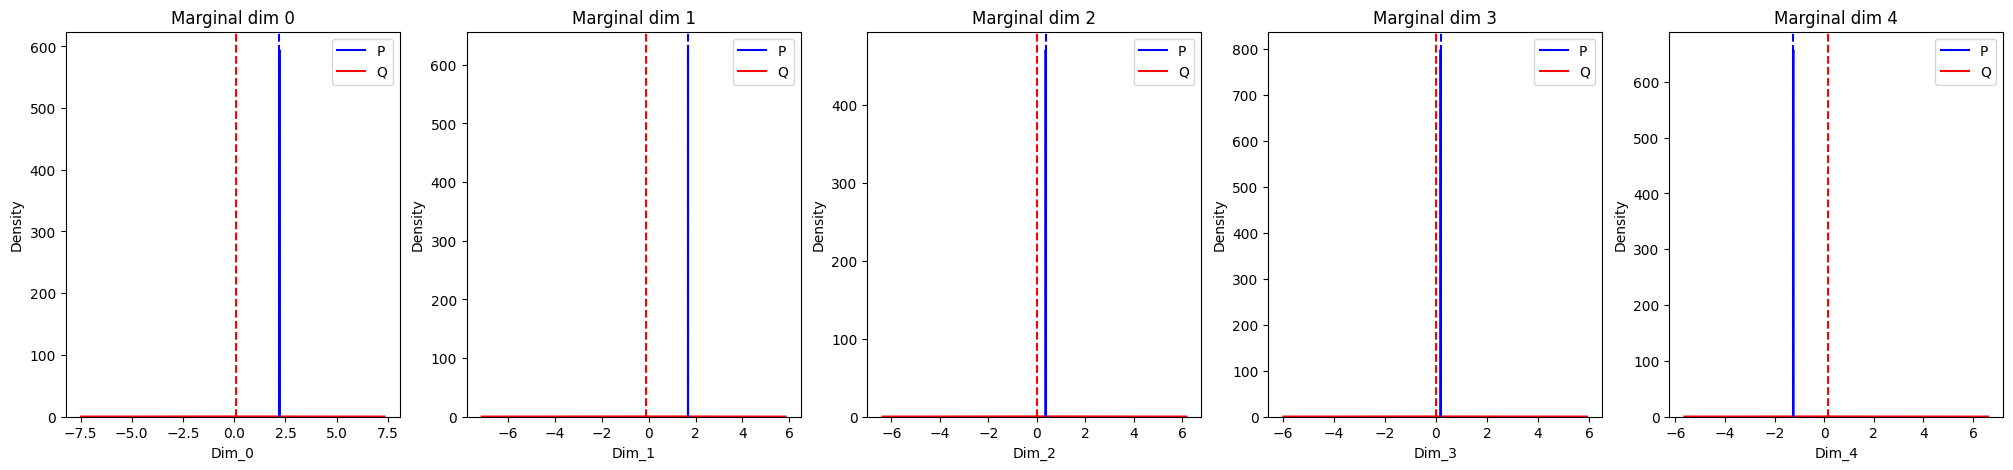

In [188]:
marginal_plots_kde_together(X_s, X_t)

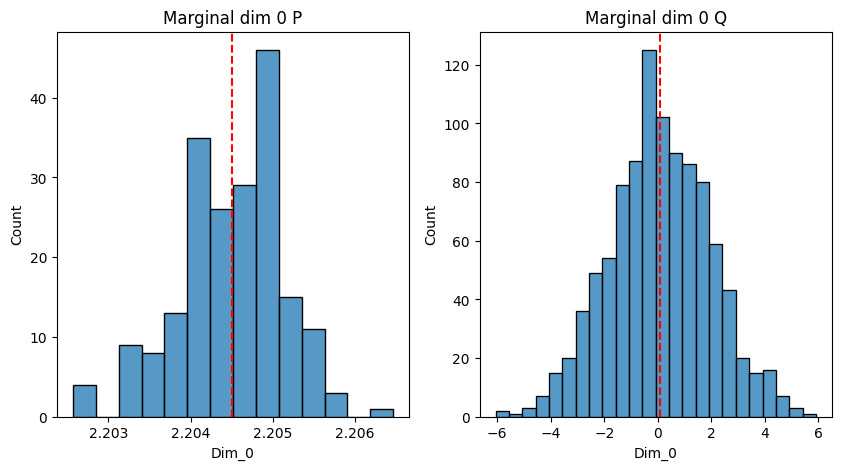

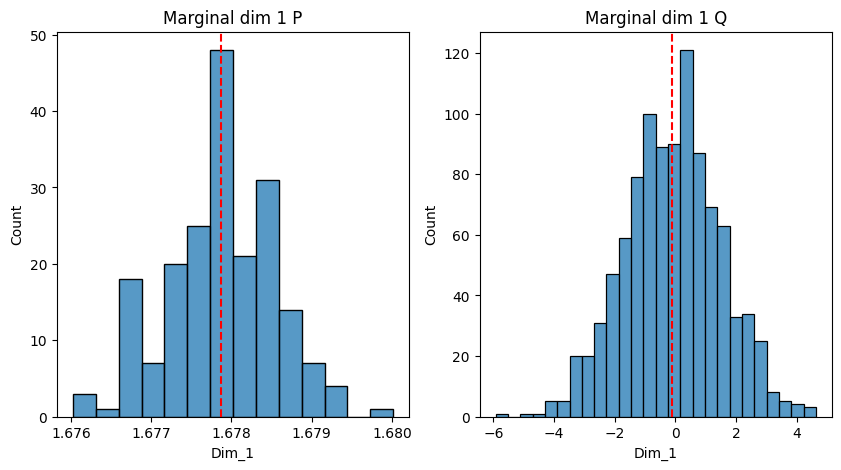

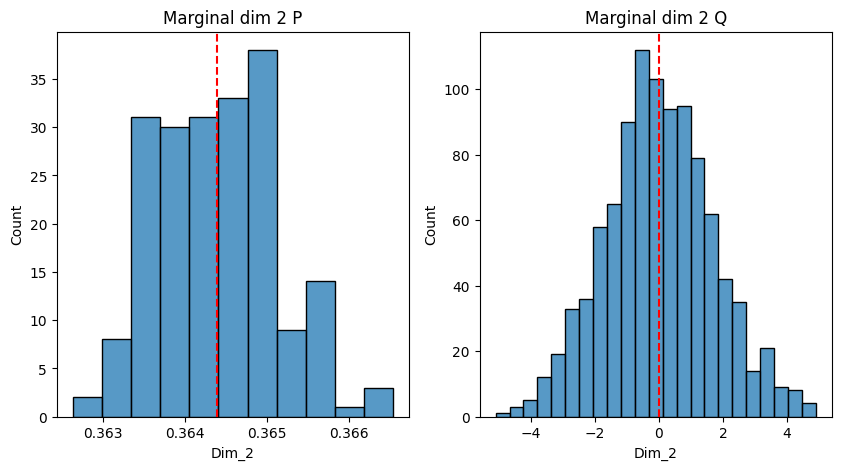

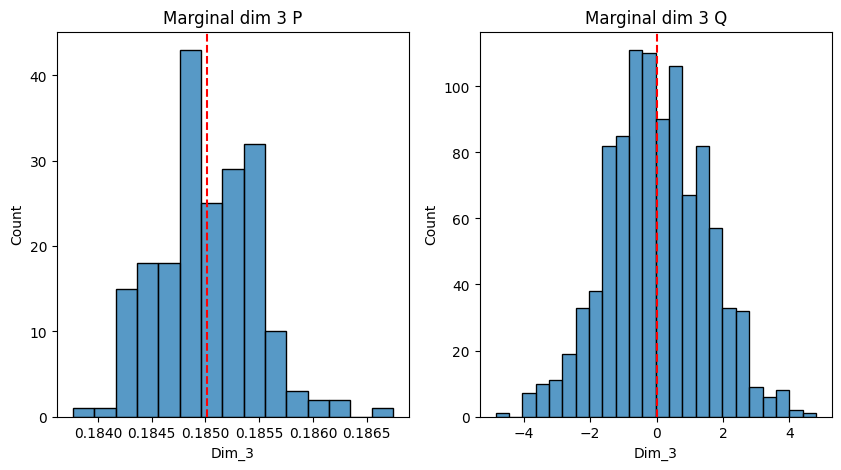

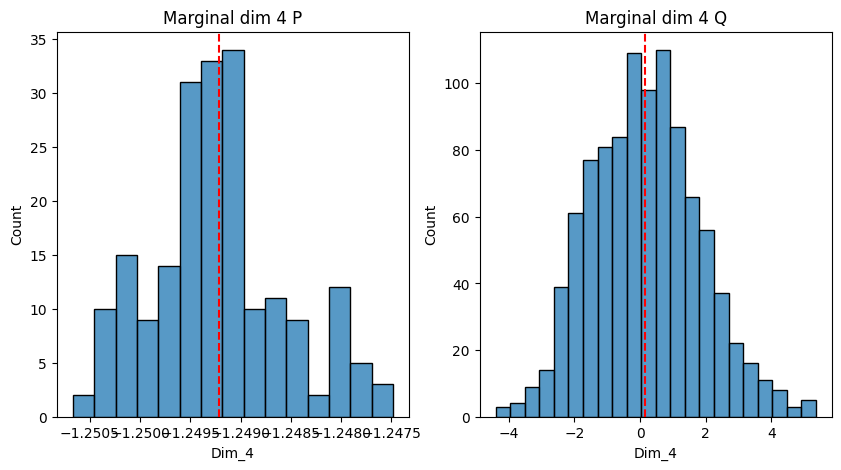

In [190]:
marginal_plots_hist_parallel(X_s, X_t)

In [ ]:
plot(X_s, X_t)

In [189]:
compare_all_metrics(X_s, X_t)

{'mean_stats': {'absolute_mean_diff': tensor(1.1674),
  'squared_mean_diff': tensor(1.9623),
  'P_mean': tensor([ 2.2045,  1.6779,  0.3644,  0.1850, -1.2492]),
  'Q_mean': tensor([ 0.0771, -0.0930,  0.0110,  0.0124,  0.1633])},
 'std_stats': {'absolute_std_diff': tensor(1.6589),
  'squared_std_diff': tensor(2.7700),
  'P_std': tensor([0.0006, 0.0007, 0.0007, 0.0005, 0.0007]),
  'Q_std': tensor([1.8915, 1.5835, 1.6868, 1.4847, 1.6509])},
 'q_025_stats': {'absolute_q_025_diff': tensor(3.7654),
  'squared_q_025_diff': tensor(16.4107),
  'P_q_025': tensor([ 2.2032,  1.6767,  0.3632,  0.1843, -1.2503]),
  'Q_q_025': tensor([-3.6282, -3.1973, -3.1892, -2.8858, -2.7496])},
 'q_075_stats': {'absolute_q_075_diff': tensor(2.7285),
  'squared_q_075_diff': tensor(9.0854),
  'P_q_075': tensor([ 2.2056,  1.6791,  0.3658,  0.1858, -1.2478]),
  'Q_q_075': tensor([3.9236, 2.9255, 3.5121, 2.7989, 3.6710])},
 'iqr_stats': {'absolute_iqr_diff': tensor(2.2362),
  'squared_iqr_diff': tensor(5.0363),
  'P_iq

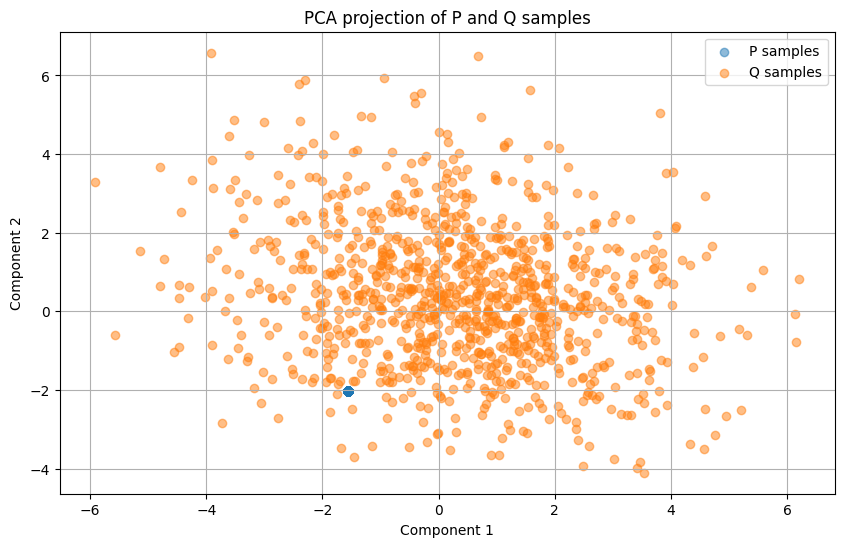

In [197]:
sample_plot_2d(X_s, X_t)

In [199]:
from PFNExperiments.LinearRegression.Evaluation.CompareModels import ModelComparison

In [237]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram1, n_warmup=10, n_samples=20)

In [257]:
comparison_model = ModelComparison(
    modelposterior=full_model,
    comparison_model=hmc_sampler
)

In [258]:
test_batch = next(iter(test_loader))

In [259]:
test_batch["x"].shape

torch.Size([150, 100, 5])

In [260]:
comparison_model.get_samples_modelposterior(test_batch["x"][0], test_batch["y"][0]).shape

torch.Size([500, 5])

In [261]:
r = comparison_model.get_samples_comparison_model(test_batch["x"][0], test_batch["y"][0])

Sample: 100%|██████████| 30/30 [00:01, 29.59it/s, step size=7.34e-04, acc. prob=1.000]


In [262]:
comparison_model.compare_samples_metrics(test_batch["x"][0], test_batch["y"][0])

Sample: 100%|██████████| 30/30 [00:00, 50.64it/s, step size=2.29e-05, acc. prob=1.000]


{'Wasserstein_distance with metric euclidean': 5.906904697418213,
 'KLD_Gaussian': 33009821696.0,
 'mean_stats': {'absolute_mean_diff': tensor(1.6183),
  'squared_mean_diff': tensor(3.1255),
  'P_mean': tensor([0.9504, 1.4060, 1.3666, 0.9282, 0.7587]),
  'Q_mean': tensor([-1.2142, -0.5967, -0.4453,  0.7141, -1.1393])},
 'std_stats': {'absolute_std_diff': tensor(2.0608),
  'squared_std_diff': tensor(4.3338),
  'P_std': tensor([2.4555, 1.9621, 1.9418, 2.3839, 1.6705]),
  'Q_std': tensor([0.0230, 0.0229, 0.0214, 0.0206, 0.0222])},
 'q_025_stats': {'absolute_q_025_diff': tensor(2.4094),
  'squared_q_025_diff': tensor(7.0340),
  'P_q_025': tensor([-3.7488, -2.4277, -2.4171, -3.8394, -2.5477]),
  'Q_q_025': tensor([-1.2669, -0.6491, -0.4943,  0.6669, -1.1901])},
 'q_075_stats': {'absolute_q_075_diff': tensor(5.6562),
  'squared_q_075_diff': tensor(32.8155),
  'P_q_075': tensor([6.1504, 5.2107, 4.8790, 5.5102, 3.9429]),
  'Q_q_075': tensor([-1.1949, -0.5771, -0.4270,  0.7316, -1.1202])},
 'iq

Sample: 100%|██████████| 30/30 [00:00, 96.22it/s, step size=9.17e-05, acc. prob=1.000]


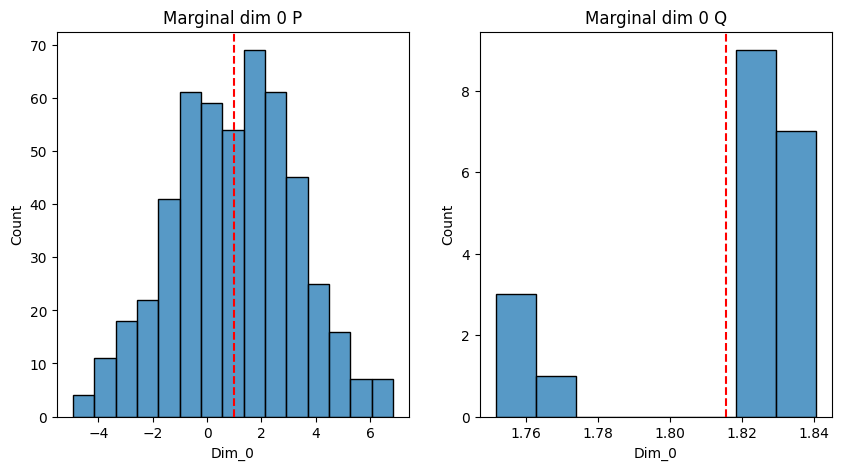

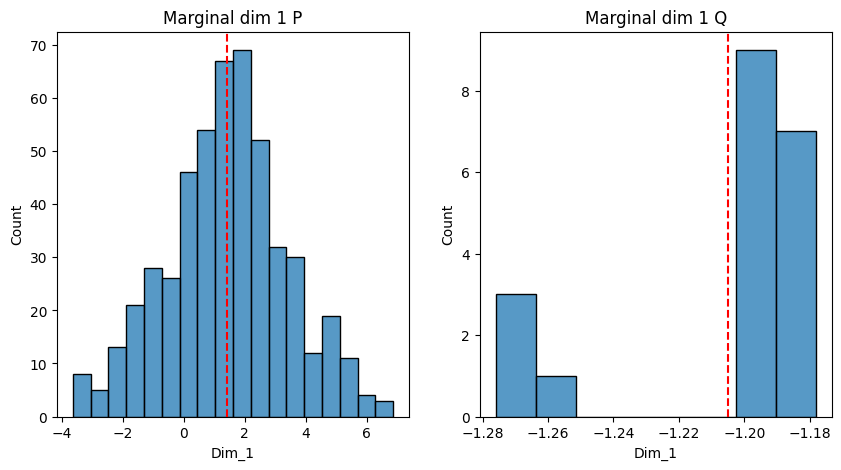

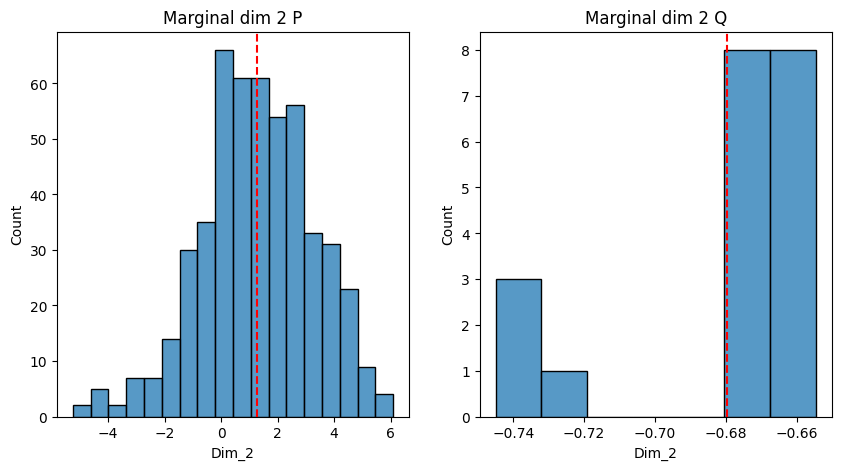

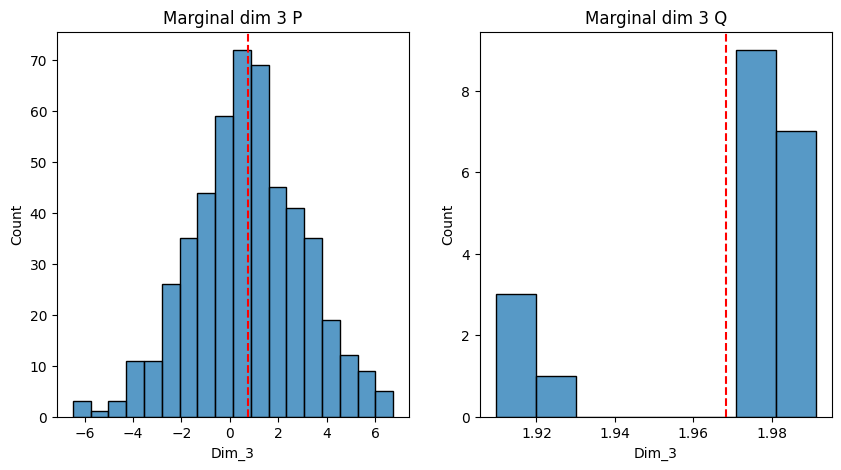

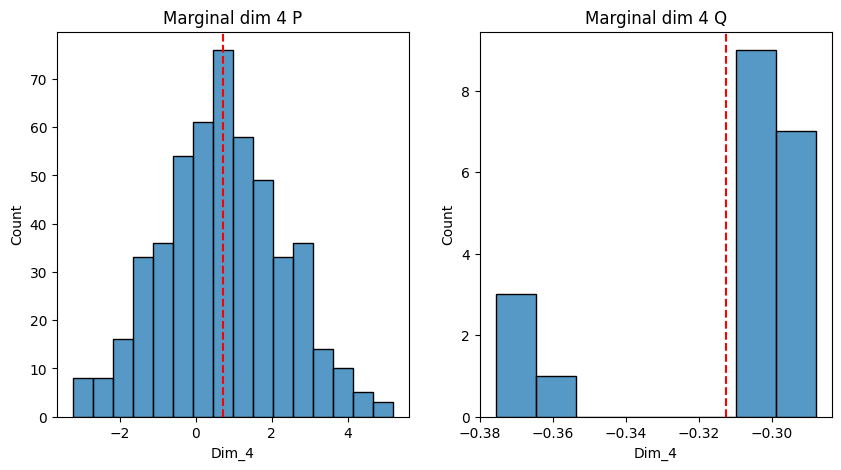

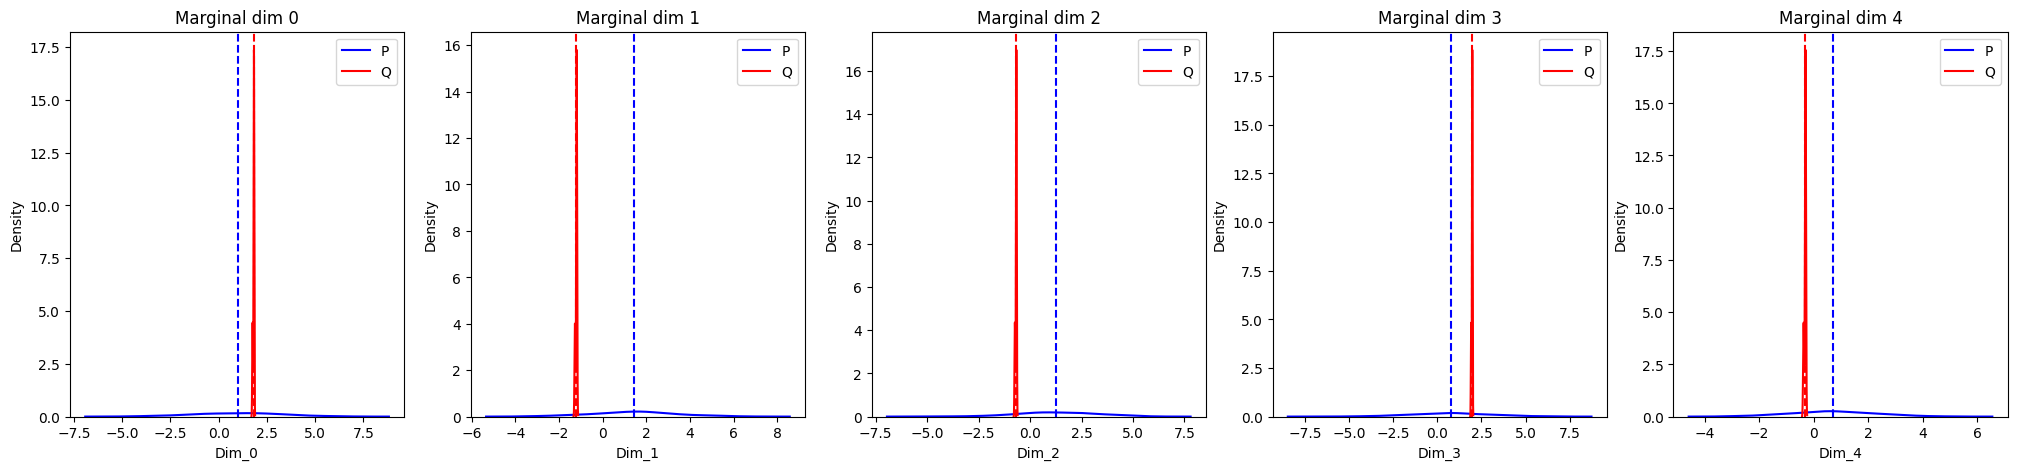

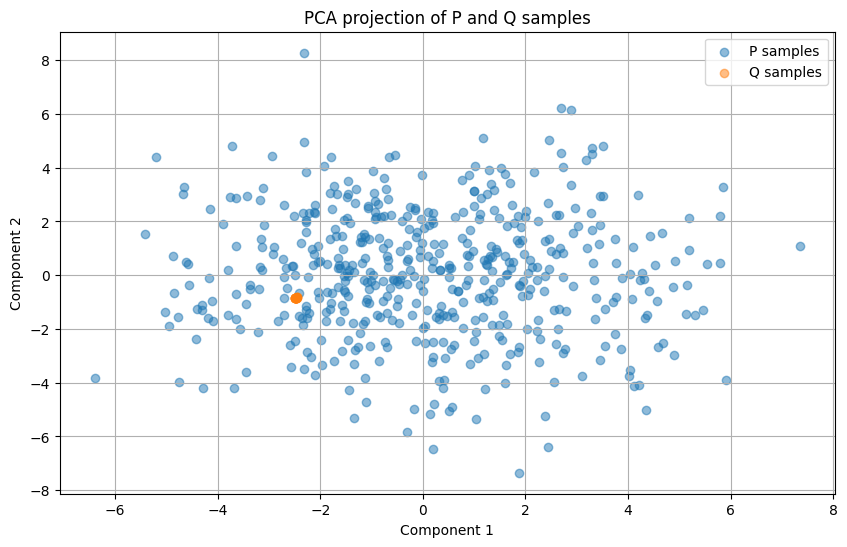

Sample: 100%|██████████| 30/30 [00:00, 48.41it/s, step size=9.17e-05, acc. prob=1.000]


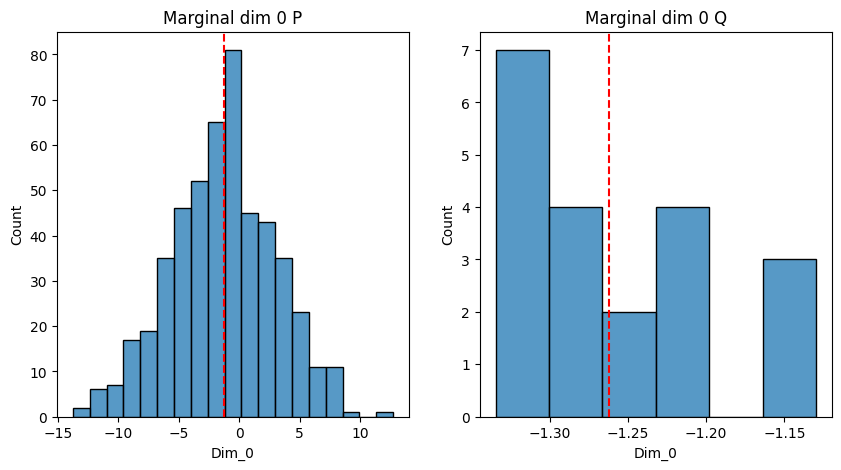

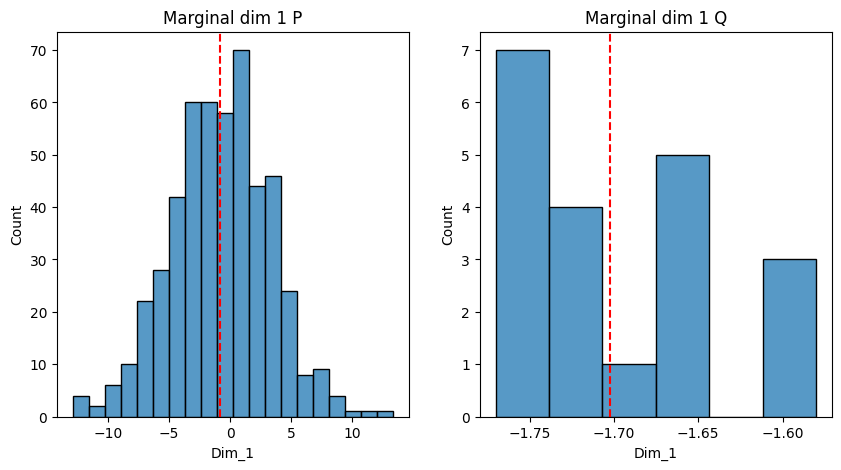

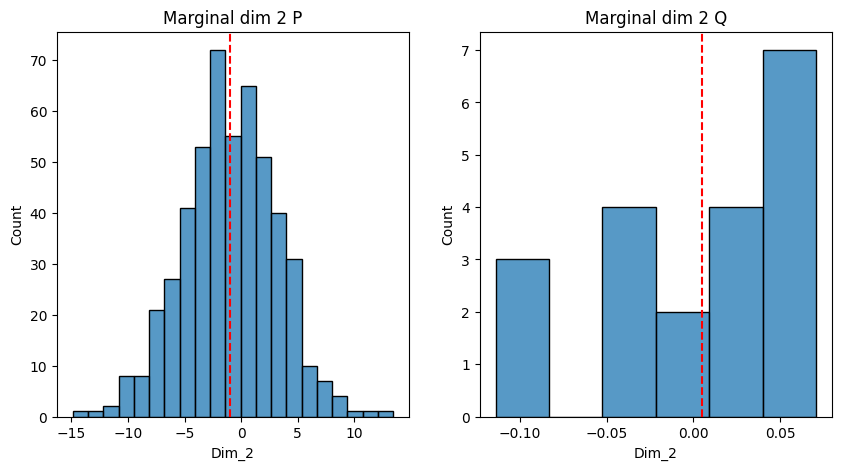

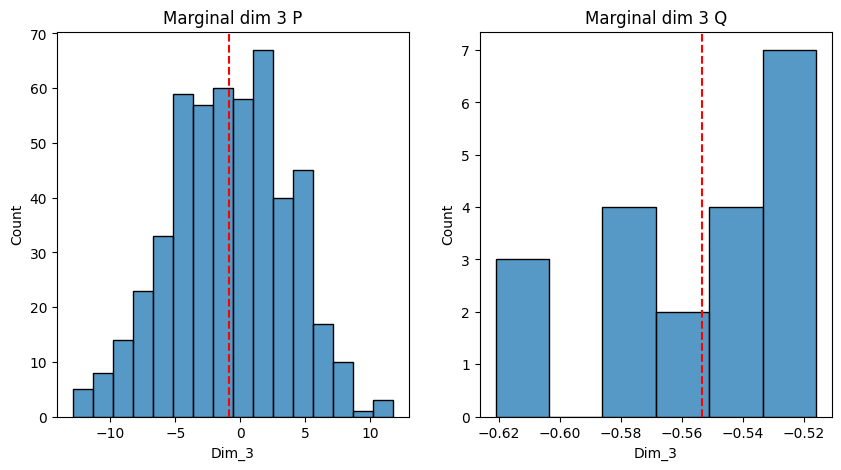

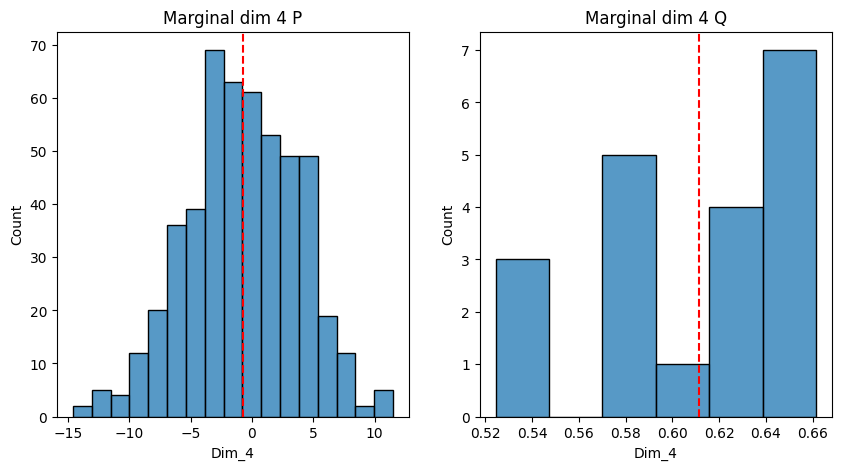

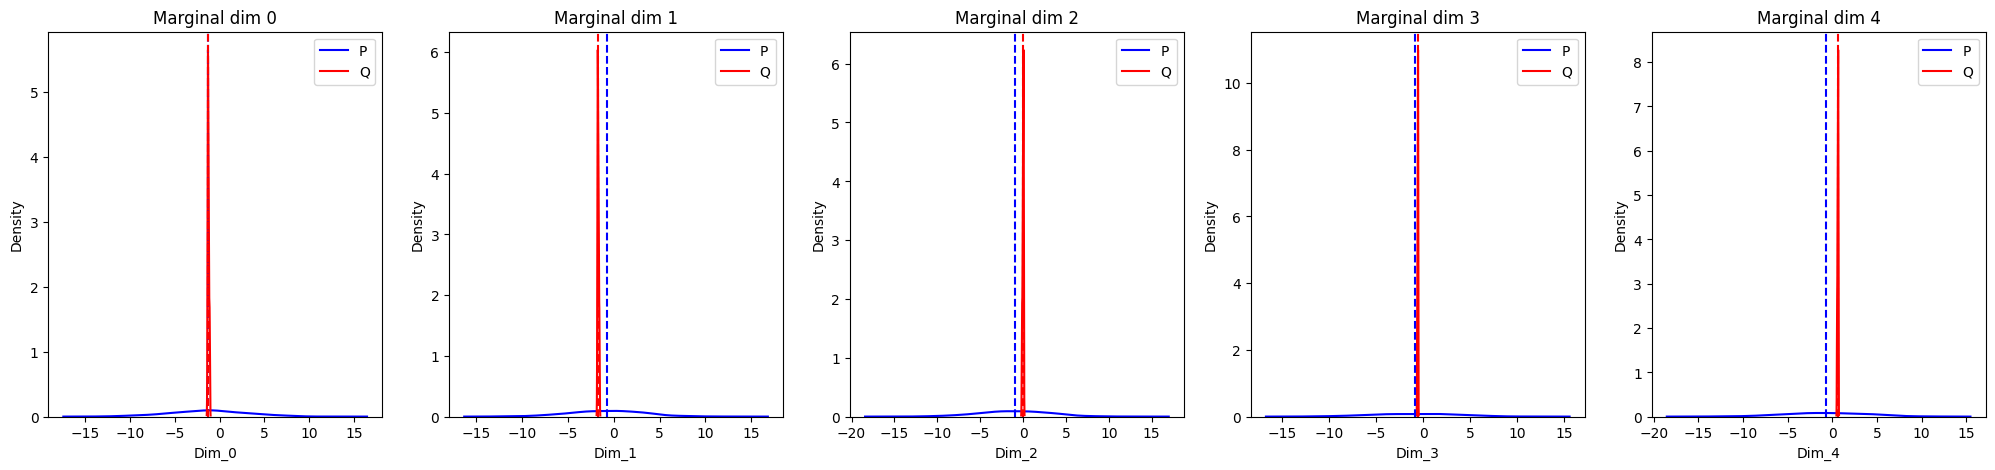

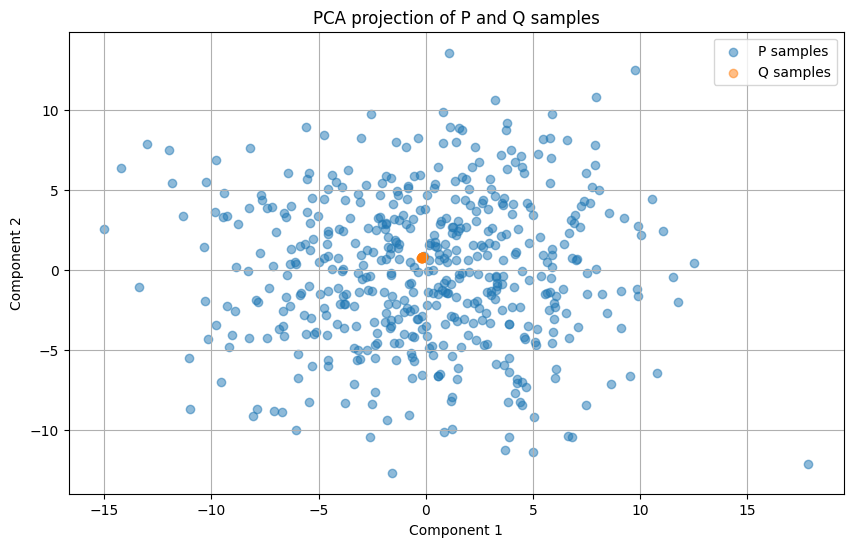

Sample: 100%|██████████| 30/30 [00:05,  5.52it/s, step size=2.00e-04, acc. prob=0.947]


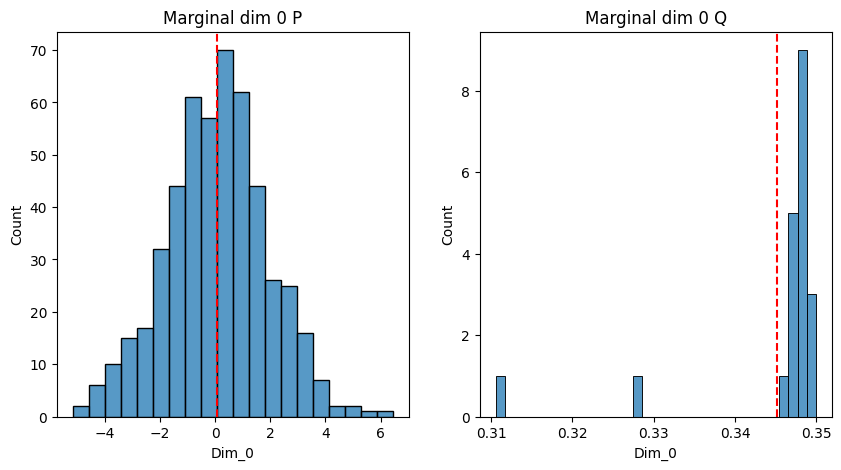

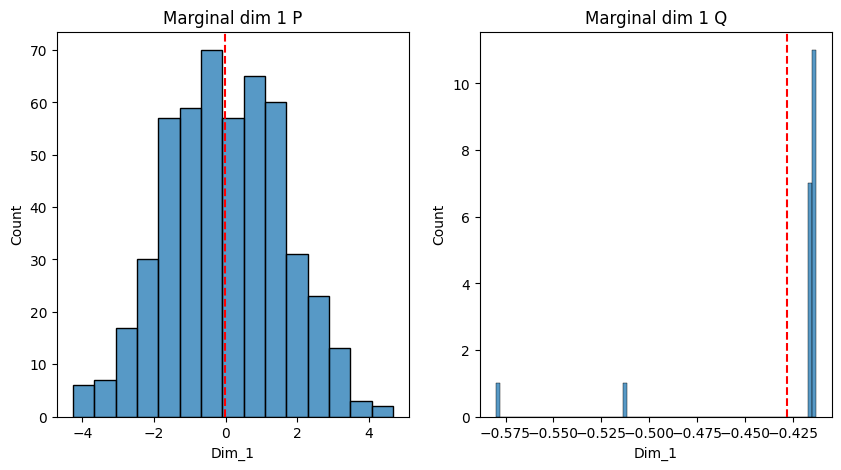

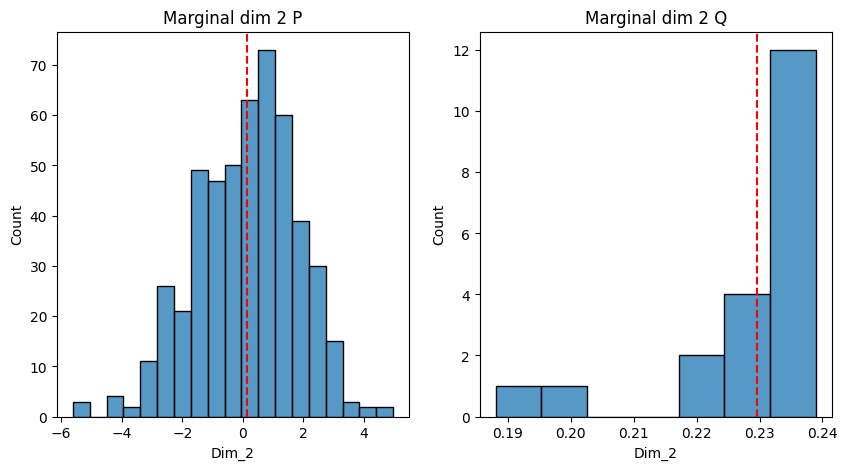

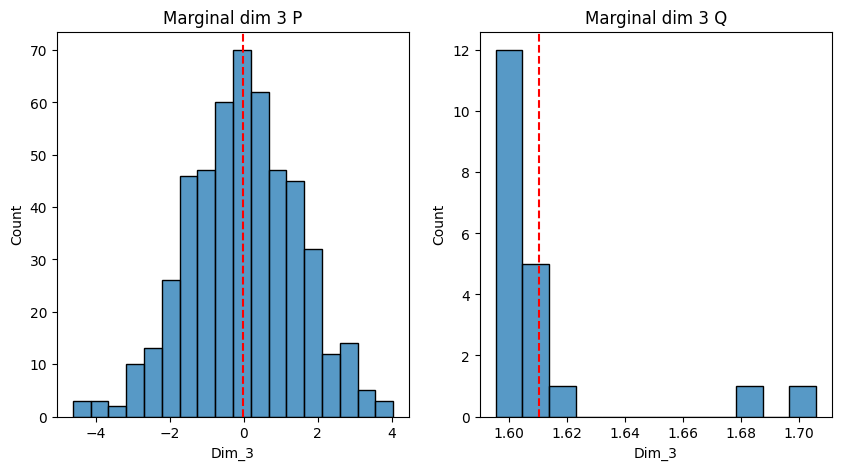

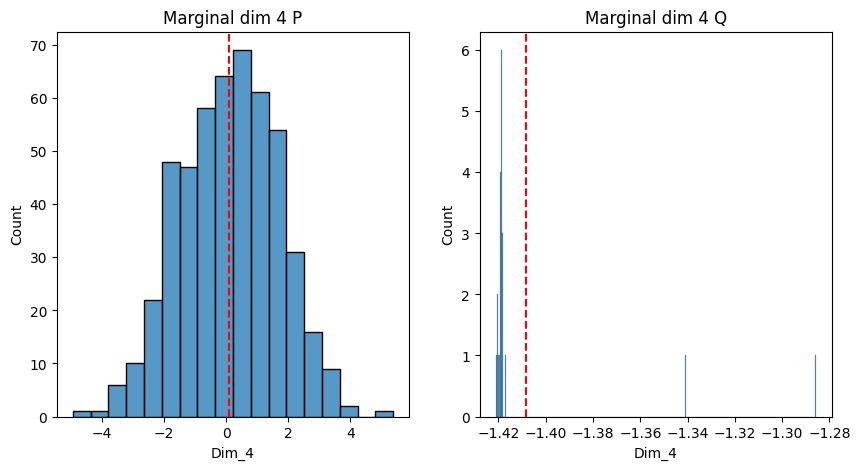

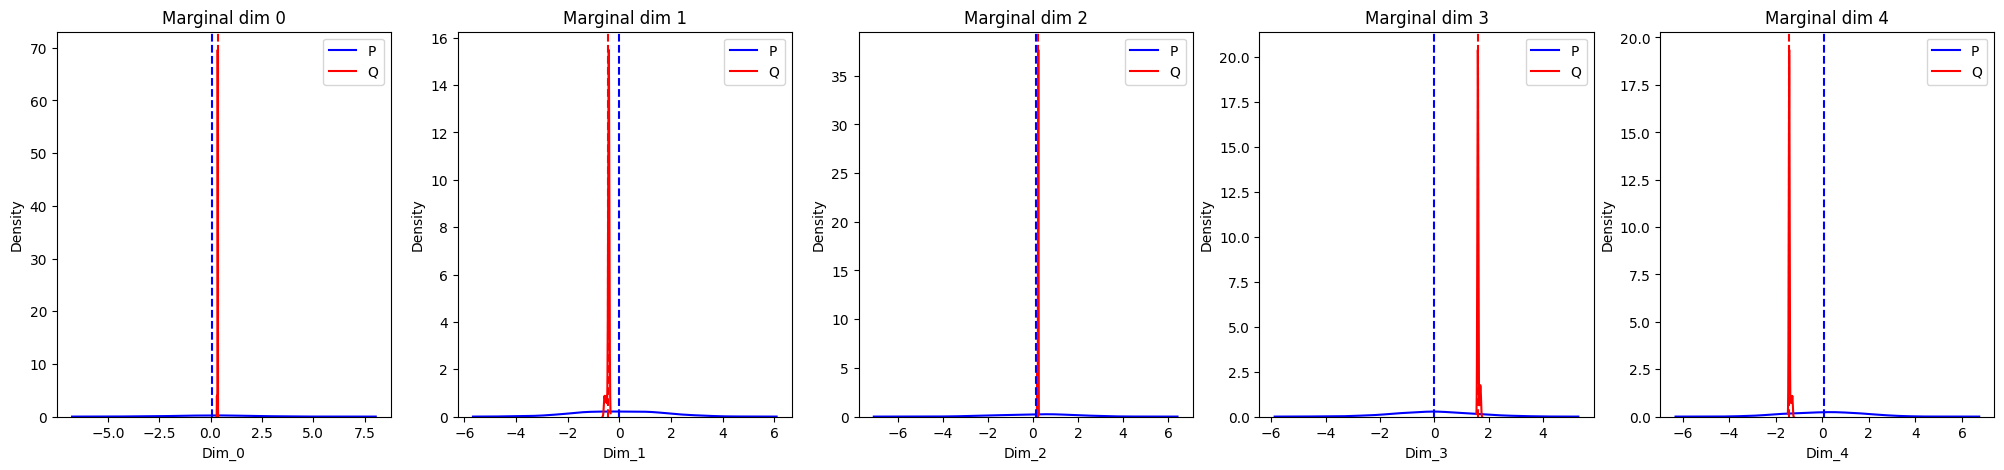

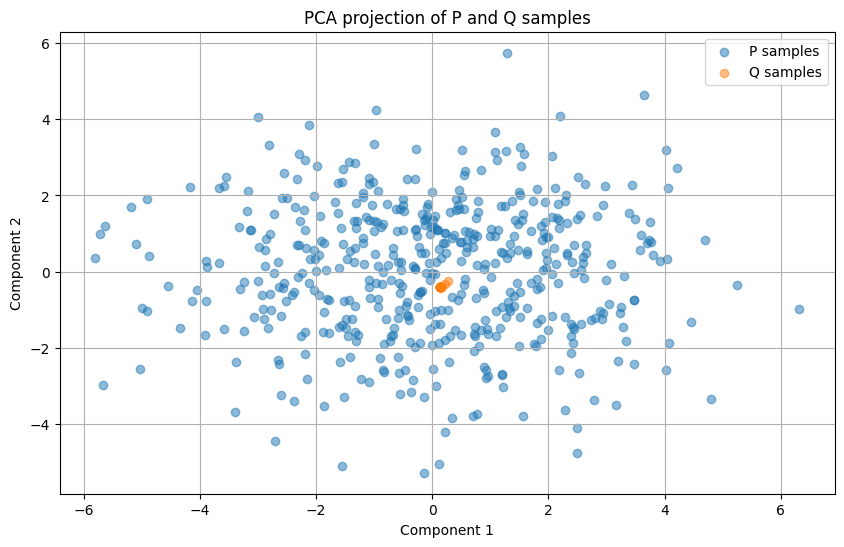

In [263]:
r = comparison_model.compare_sample_metrics_batch(test_batch["x"][:3], test_batch["y"][:3])

In [264]:
r[0]

[{'Wasserstein_distance with metric euclidean': 5.619427680969238,
  'KLD_Gaussian': 636692992.0,
  'mean_stats': {'absolute_mean_diff': tensor(1.5340),
   'squared_mean_diff': tensor(2.8005),
   'P_mean': tensor([0.9817, 1.4261, 1.2827, 0.7485, 0.7100]),
   'Q_mean': tensor([ 1.8157, -1.2049, -0.6798,  1.9685, -0.3125])},
  'std_stats': {'absolute_std_diff': tensor(1.9883),
   'squared_std_diff': tensor(4.0242),
   'P_std': tensor([2.2798, 1.9696, 1.9755, 2.2981, 1.5696]),
   'Q_std': tensor([0.0300, 0.0332, 0.0305, 0.0276, 0.0296])},
  'q_025_stats': {'absolute_q_025_diff': tensor(3.2742),
   'squared_q_025_diff': tensor(14.4036),
   'P_q_025': tensor([-3.4940, -2.3970, -2.7703, -3.9902, -2.4496]),
   'Q_q_025': tensor([ 1.7527, -1.2748, -0.7439,  1.9105, -0.3746])},
  'q_075_stats': {'absolute_q_075_diff': tensor(4.6438),
   'squared_q_075_diff': tensor(22.8964),
   'P_q_075': tensor([5.4445, 5.3028, 4.8233, 5.5260, 3.8329]),
   'Q_q_075': tensor([ 1.8404, -1.1783, -0.6548,  1.9911,

In [265]:
r[1]

{'Wasserstein_distance with metric euclidean': tensor(6.3226),
 'KLD_Gaussian': tensor(1.0603e+09),
 'mean_stats': {'absolute_mean_diff': tensor(1.0118),
  'squared_mean_diff': tensor(1.5212),
  'P_mean': tensor(0.0509),
  'Q_mean': tensor(-0.0644)},
 'std_stats': {'absolute_std_diff': tensor(2.6082),
  'squared_std_diff': tensor(8.1787),
  'P_std': tensor(2.6455),
  'Q_std': tensor(0.0373)},
 'q_025_stats': {'absolute_q_025_diff': tensor(5.0558),
  'squared_q_025_diff': tensor(34.1085),
  'P_q_025': tensor(-5.1829),
  'Q_q_025': tensor(-0.1271)},
 'q_075_stats': {'absolute_q_075_diff': tensor(5.1426),
  'squared_q_075_diff': tensor(31.3315),
  'P_q_075': tensor(5.1273),
  'Q_q_075': tensor(-0.0153)},
 'iqr_stats': {'absolute_iqr_diff': tensor(3.5500),
  'squared_iqr_diff': tensor(15.2068),
  'P_iqr': tensor(3.5838),
  'Q_iqr': tensor(0.0338)},
 'cov_stats': {'absolute_cov_diff': tensor(2.4134),
  'squared_cov_diff': tensor(26.0251),
  'P_cov': tensor(1.1895),
  'Q_cov': tensor(0.0003)

In [266]:
r[2]

{'Wasserstein_distance with metric euclidean': tensor(2.6310),
 'KLD_Gaussian': tensor(1.3027e+09),
 'mean_stats': {'absolute_mean_diff': tensor(0.4534),
  'squared_mean_diff': tensor(1.1173),
  'P_mean': tensor(0.8545),
  'Q_mean': tensor(1.1718)},
 'std_stats': {'absolute_std_diff': tensor(1.4139),
  'squared_std_diff': tensor(8.4501),
  'P_std': tensor(1.2271),
  'Q_std': tensor(0.0175)},
 'q_025_stats': {'absolute_q_025_diff': tensor(3.1560),
  'squared_q_025_diff': tensor(36.9238),
  'P_q_025': tensor(3.0944),
  'Q_q_025': tensor(1.1768)},
 'q_075_stats': {'absolute_q_075_diff': tensor(2.4196),
  'squared_q_075_diff': tensor(26.4631),
  'P_q_075': tensor(1.8063),
  'Q_q_075': tensor(1.1547)},
 'iqr_stats': {'absolute_iqr_diff': tensor(1.9347),
  'squared_iqr_diff': tensor(15.8541),
  'P_iqr': tensor(1.7013),
  'Q_iqr': tensor(0.0347)},
 'cov_stats': {'absolute_cov_diff': tensor(2.4906),
  'squared_cov_diff': tensor(40.3194),
  'P_cov': tensor(4.9951),
  'Q_cov': tensor(0.0020)},
 

In [273]:
from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference, make_guide_program_gamma_gamma

In [ ]:
guide_gamma_gamma = make_guide_program_gamma_gamma()